In [0]:
#! pip install tensorflow-gpu==2.0.0-beta1

In [2]:
%matplotlib inline

import os
import numpy as np
import pylab as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

Images shape: (420, 64, 64)
Segmentation masks shape: (420, 64, 64)


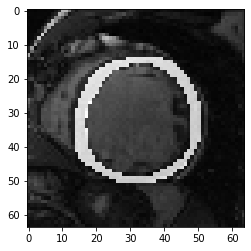

In [3]:
![ -f scd_lvsegs.npz ] ||  wget https://github.com/Warvito/MRAI_workshop_tensorflow/raw/master/scd_lvsegs.npz

data = np.load('scd_lvsegs.npz')  # load all the data from the archive

images = data['images']  # images in BHW array order
segs = data['segs']  # segmentations in BHW array order

images = images.astype(np.float32) / images.max()  # normalize images
segs = segs.astype(np.float32)

print('Images shape: ' + str(images.shape))
print('Segmentation masks shape: ' + str(segs.shape))

plt.imshow(images[60] + segs[60] * 0.2, cmap='gray')  # show image 50 with segmentation

In [0]:
images = images.reshape(images.shape[0], 64, 64, 1)
segs = segs.reshape(segs.shape[0], 64, 64, 1)

In [0]:
test_index = 10 # keep the last 6/10 cases for testing

# Divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:-test_index], segs[:-test_index]
test_images, test_segs = images[-test_index:], segs[-test_index:]

In [0]:
def dice_coef_loss(y_true, y_pred, smooth=1e-5): #5
    """ Function to calculate the dice loss.

    Dice = (2*|X & Y|) / (|X| + |Y|)
    """   
    batch_size = tf.shape(y_true)[0]
    y_pred = tf.sigmoid(y_pred)

    y_true = tf.reshape(y_true, [batch_size, -1])
    y_pred = tf.reshape(y_pred, [batch_size, -1])

    intersection = tf.multiply(y_pred, y_true)
    sums = y_pred + y_true

    score = 2.0 * (tf.reduce_sum(intersection, axis=1) + smooth) / (tf.reduce_sum(sums, axis=1) + smooth)  
    
    return 1 - tf.cast(tf.reduce_sum(score), tf.float32) / tf.cast(batch_size, tf.float32)

In [7]:
# Segmentation network
inputs = keras.Input(shape=(64, 64, 1))

x = keras.layers.Conv2D(filters=2, kernel_size=3, padding='same', activation='linear', use_bias='False')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = keras.layers.Conv2D(filters=4, kernel_size=3, padding='same', activation='linear', use_bias='False')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='linear')(x)

x = keras.layers.Conv2D(filters=4, kernel_size=3, padding='same', activation='linear', use_bias='False')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)

x = keras.layers.Conv2D(filters=2, kernel_size=3, padding='same', activation='linear', use_bias='False')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)

outputs = keras.layers.Conv2D(filters=1, kernel_size=3, padding='same')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 2)         20        
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 2)         8         
_________________________________________________________________
activation (Activation)      (None, 64, 64, 2)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         76        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 4)         16    

In [0]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss=dice_coef_loss,
              optimizer=optimizer)

In [10]:
%%time
n_epochs = 2500
history = model.fit(train_images, train_segs,
                    batch_size=512,
                    epochs=n_epochs,
                    verbose=1)

Train on 410 samples
Epoch 1/2500
410/410 [==============================] - 3s 6ms/sample - loss: 0.9139
Epoch 2/2500
410/410 [==============================] - 0s 57us/sample - loss: 0.9128
Epoch 3/2500
410/410 [==============================] - 0s 57us/sample - loss: 0.9118
Epoch 4/2500
410/410 [==============================] - 0s 57us/sample - loss: 0.9108
Epoch 5/2500
410/410 [==============================] - 0s 54us/sample - loss: 0.9098
Epoch 6/2500
410/410 [==============================] - 0s 56us/sample - loss: 0.9088
Epoch 7/2500
410/410 [==============================] - 0s 55us/sample - loss: 0.9078
Epoch 8/2500
410/410 [==============================] - 0s 55us/sample - loss: 0.9069
Epoch 9/2500
410/410 [==============================] - 0s 55us/sample - loss: 0.9061
Epoch 10/2500
410/410 [==============================] - 0s 57us/sample - loss: 0.9052
Epoch 11/2500
410/410 [==============================] - 0s 55us/sample - loss: 0.9044
Epoch 12/2500
410/410 [=========

In [0]:
sample = (train_images[60])[np.newaxis, :]
sample_groud_truth = (train_segs[60])[np.newaxis, :]
pred_sample = model.predict(sample)

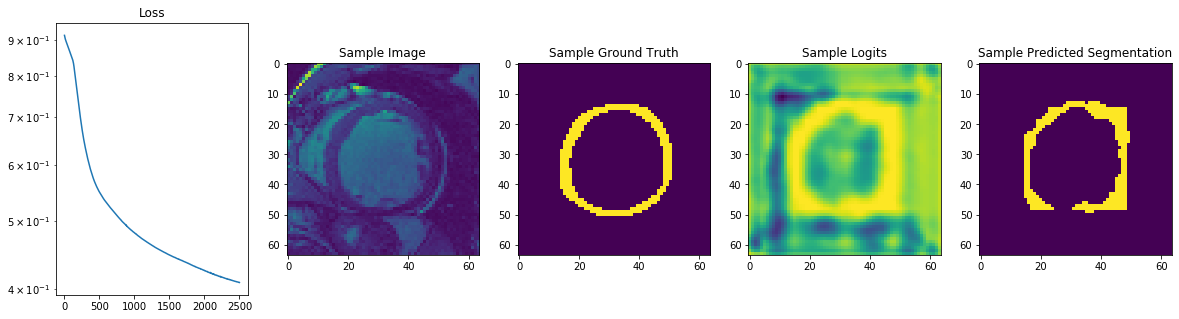

In [12]:
# Sample an image from the training data and look at the segmentation the network predicted for it
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].set_title('Loss')
ax[0].semilogy(history.history['loss'])
ax[1].set_title('Sample Image')
ax[1].imshow(sample[0, :, :, 0])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(sample_groud_truth[0, :, :, 0])
ax[3].set_title('Sample Logits')
ax[3].imshow(pred_sample[0, :, :, 0])
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(pred_sample[0, :, :, 0] > 0.5)

10/10 [==============================] - 0s 547us/sample - loss: 0.6825
Test loss: 0.6824590563774109


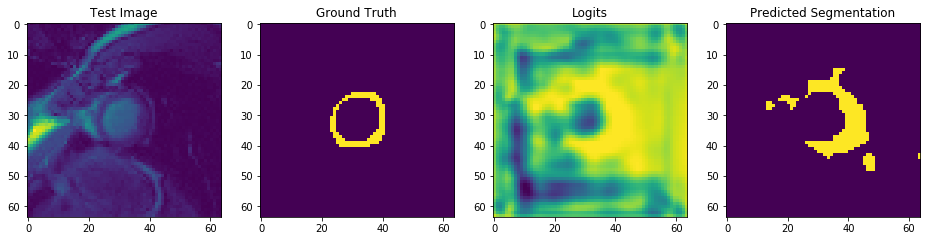

In [14]:
testloss = model.evaluate(test_images, test_segs,
                          batch_size=32)

pred = model.predict(test_images)

seg = pred > 0.5

fig, ax = plt.subplots(1, 4, figsize=(16, 5))
ax[0].set_title('Test Image')
ax[0].imshow(test_images[0, :, :, 0])
ax[1].set_title('Ground Truth')
ax[1].imshow(test_segs[0, :, :, 0])
ax[2].set_title('Logits')
ax[2].imshow(pred[0, :, :, 0])
ax[3].set_title('Predicted Segmentation')
ax[3].imshow(seg[0, :, :, 0])

print('Test loss:', testloss)